In [1]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

# datasets
from my_code.datasets.surreal_cached_train_dataset import SurrealTrainDataset
from my_code.datasets.surreal_cached_test_dataset import SurrealTestDataset

# models
from my_code.models.diag_conditional import DiagConditionedUnet
from diffusers import DDPMScheduler

In [9]:
import yaml
import torch

exp_dir = '/home/s94zalek/shape_matching/my_code/experiments/test'

config = yaml.safe_load(open(exp_dir + '/config.yaml', 'r'))

dataset_base_folder = '/home/s94zalek/shape_matching/data/SURREAL_full/full_datasets'
test_dataset = SurrealTestDataset(f'{dataset_base_folder}/{config["dataset_name"]}/test')

In [16]:
import torch

model = DiagConditionedUnet(
    {
            'sample_size': 28,
            'in_channels': 2,
            'out_channels': 1,
            'layers_per_block': 2,
            'block_out_channels': (32, 64, 64),
            'down_block_types': (
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D",
            ),
            'up_block_types': (
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
            ),
        }
)
# load checkpoint_29.pt
model.load_state_dict(torch.load(exp_dir + '/checkpoint_29.pt'))
model = model.to('cuda')

In [87]:
from tqdm import tqdm
from diffusers import DDPMScheduler

batch_size = 1024
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2',
                                clip_sample=True)

x_sampled_list = []
for batch in test_loader:
    
    # print(batch)
    x_gt, y = batch['second']['C_gt_xy'], batch['second']['evals']  
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Prepare random x to start from, plus some desired labels y
    x_sampled = torch.rand_like(x_gt).to(device)  
    y = y.to(device)    
        
    # Sampling loop
    for i, t in tqdm(enumerate(noise_scheduler.timesteps), total=noise_scheduler.config.num_train_timesteps):

        # Get model pred
        with torch.no_grad():
            residual = model(x_sampled, t,
                                conditioning=y
                                ).sample

        # Update sample with step
        x_sampled = noise_scheduler.step(residual, t, x_sampled).prev_sample
        
    break
    x_sampled.append(x.cpu())
    


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:21<00:00,  4.96it/s]


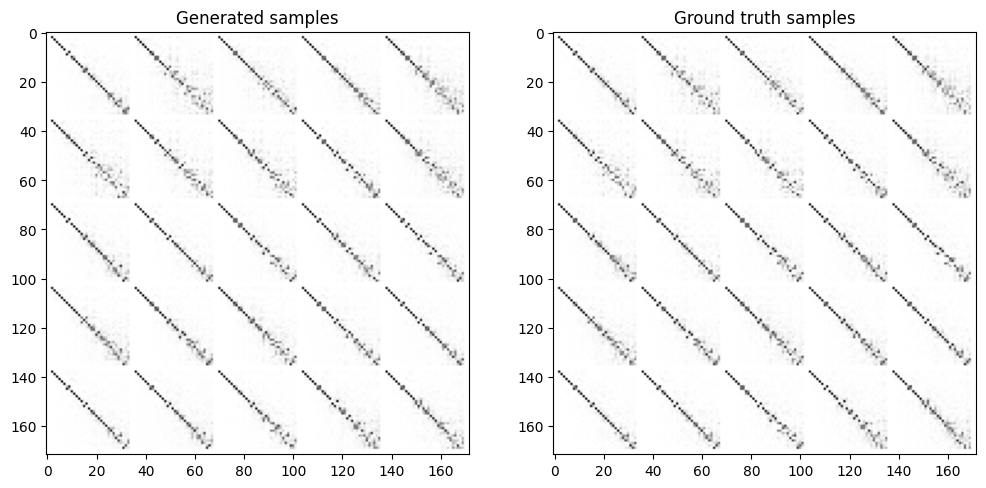

In [90]:
import torchvision
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax_0 = ax[0].imshow(torchvision.utils.make_grid(
    (x_sampled[:25].detach().cpu() + 1) / 2, nrow=5, value_range=(-1, 1)#, scale_each=True
    )[0], cmap='Greys')
# plt.colorbar(ax_plot, ax=ax)

ax[0].set_title('Generated samples')

ax_1 = ax[1].imshow(torchvision.utils.make_grid(
    x_gt[:25].detach().cpu().abs(), nrow=5, value_range=(-1, 1)#, scale_each=True
    )[0], cmap='Greys')

ax[1].set_title('Ground truth samples')


# ax.axis('off')

plt.show()

In [113]:
# import sys
# sys.path.append('/home/s94zalek/shape_matching')

import utils.fmap_util as fmap_util
import metrics.geodist_metric as geodist_metric


def compare_fmap_with_gt(
    Cxy_est, data_x, data_y
    ):
    
    # hard correspondence 
    p2p_gt = fmap_util.fmap2pointmap(
        C12=data_y['C_gt_xy'][0],
        evecs_x=data_x['evecs'],
        evecs_y=data_y['evecs'],
        )
    p2p_est = fmap_util.fmap2pointmap(
        Cxy_est[0],
        evecs_x=data_x['evecs'],
        evecs_y=data_y['evecs'],
        )
    
    # soft correspondence
    Pyx_gt = data_y['evecs'] @ data_y['C_gt_xy'][0] @ data_x['evecs_trans']
    Pyx_est = data_y['evecs'] @ Cxy_est[0] @ data_x['evecs_trans']
    
    # print('p2p_gt', p2p_gt)
    
    # distance matrices
    dist_x = torch.cdist(data_x['verts'], data_x['verts'])
    dist_y = torch.cdist(data_y['verts'], data_y['verts'])

    # geodesic error
    geo_err_gt = geodist_metric.calculate_geodesic_error(dist_x, data_x['corr'], data_y['corr'], p2p_gt, return_mean=False)    
    geo_err_est = geodist_metric.calculate_geodesic_error(dist_x, data_x['corr'], data_y['corr'], p2p_est, return_mean=False)
    
    # print results
    # print(f'Cxy_est - Cxy_gt: {torch.sum(torch.abs(Cxy_est - data_y["C_gt_xy"])):.2f}')
    # print(f'Pyx_est - Pyx_gt: {torch.sum(torch.abs(Pyx_est - Pyx_gt)):.2f}')
    # print(f'Geodesic error GT: {geo_err_gt.abs().sum():.2f}, EST: {geo_err_est.abs().sum():.2f}')
    
    return geo_err_gt, geo_err_est, p2p_gt, p2p_est

In [114]:
geo_err_gt_list = []
geo_err_est_list = []
p2p_gt_list = []
p2p_est_list = []

for i in tqdm(range(100)):#tqdm(range(batch['first']['corr'].shape[0])):

    batch_i = {
        'first': {k: v[i] for k, v in batch['first'].items()},
        'second': {k: v[i] for k, v in batch['second'].items()}
    }
    
    fmap_i = x_sampled[i].cpu()
    fmap_i = (fmap_i + 1) / 2
    
    # make random signs
    signs = torch.randint(0, 2, (fmap_i.shape[0], 1, 1)).float() * 2 - 1
    # fmap_i = fmap_i * signs
    fmap_i = fmap_i * torch.sign(x_gt[i])
    

    geo_err_gt, geo_err_est, p2p_gt, p2p_est = compare_fmap_with_gt(
        Cxy_est=fmap_i,
        data_x=batch_i['first'],
        data_y=batch_i['second']
    )
    
    # print(f'Geodesic error GT: {geo_err_gt.abs().sum():.2f}, EST: {geo_err_est.abs().sum():.2f}')
    
    geo_err_gt_list.append(geo_err_gt.abs().sum())
    geo_err_est_list.append(geo_err_est.abs().sum())
    p2p_gt_list.append(p2p_gt)
    p2p_est_list.append(p2p_est)
    
geo_err_gt_list = torch.tensor(geo_err_gt_list)
geo_err_est_list = torch.tensor(geo_err_est_list)
    
# sum
print(f'Sum GT: {geo_err_gt_list.sum():.2f}, EST: {geo_err_est_list.sum():.2f}')
# mean
print(f'Mean GT: {geo_err_gt_list.mean():.2f}, EST: {geo_err_est_list.mean():.2f}')

# std
print(f'STD GT: {geo_err_gt_list.std():.2f}, EST: {geo_err_est_list.std():.2f}')
# std
# median
print(f'Median GT: {geo_err_gt_list.median():.2f}, EST: {geo_err_est_list.median():.2f}')

# min / max
print(f'Min GT: {geo_err_gt_list.min():.2f}, EST: {geo_err_est_list.min():.2f}')
print(f'Max GT: {geo_err_gt_list.max():.2f}, EST: {geo_err_est_list.max():.2f}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.68it/s]

Sum GT: 20860.39, EST: 23697.06
Mean GT: 208.60, EST: 236.97
STD GT: 39.19, EST: 44.74
Median GT: 193.27, EST: 224.14
Min GT: 149.23, EST: 150.87
Max GT: 331.26, EST: 344.07


In [115]:
# sort the indices according to the geodesic error, highest first
sorted_indices = torch.argsort(geo_err_est_list, descending=True)

batch_highest_error = {
    'first': {k: v[sorted_indices[0]] for k, v in batch['first'].items()},
    'second': {k: v[sorted_indices[0]] for k, v in batch['second'].items()}
}

In [ ]:
import trimesh
import numpy as np

scene = trimesh.Scene()

cmap = trimesh.visual.color.interpolate(batch_highest_error['first']['verts'][:, 1], 'jet')

# add the first mesh
mesh1 = trimesh.Trimesh(vertices=batch_highest_error['first']['verts'].cpu().numpy(), faces=batch_highest_error['first']['faces'].cpu().numpy())
mesh1.visual.vertex_colors = cmap[:len(mesh1.vertices)].clip(0, 255)
scene.add_geometry(mesh1)

mesh2 = trimesh.Trimesh(vertices=batch_highest_error['second']['verts'].cpu().numpy() + np.array([1, 0, 0]), faces=batch_highest_error['second']['faces'].cpu().numpy())
cmap2 = cmap[
             p2p_est_list[sorted_indices[0]].cpu().numpy().astype(int)
             ][:len(mesh2.vertices)]
mesh2.visual.vertex_colors = cmap2
scene.add_geometry(mesh2)

scene.show()


In [81]:
difference = np.abs(cmap / 255 - cmap[p2p] / 255)

In [101]:
difference.shape

(6890, 4)

In [ ]:
# get indices with nonzero elements of cmap/255 - cmap[p2p]/255

idx_nonzero = np.where(np.sum(difference, axis=1) > 0)[0]

for i in idx_nonzero:
    print(f'Vertex {i} has a difference of {difference[i]}: {cmap[i] / 255} vs {cmap[p2p][i] / 255}')